sources: https://stackoverflow.com/questions/61297312/finding-the-bounding-boxes-of-different-symbols-letters

In [29]:
import numpy as np
import keras
from keras import layers
import cv2
import pickle
import os

from matplotlib import pyplot as plt
from pygments.formatters import img

# Segmentation using bounding boxes


In [57]:
def find_bboxes(img):
    bboxes = []
    
    # store state of img after each stage
    img_stages = []
    
    #turn image into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_stages.append(gray)
    
    #binarisation
    ret, binary_inv = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    img_stages.append(binary_inv)

    #dilation
    kernel_dilate = np.ones((3,3), np.uint8)
    imgDilate = cv2.dilate(binary_inv, kernel_dilate, iterations=5)
    img_stages.append(imgDilate)
    
    #finding contours
    contours, _ = cv2.findContours(imgDilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #find bboxes    
    for contour in contours:
        bbox = cv2.boundingRect(contour)
        bboxes.append(bbox)
            
    #draw bbox on img
    bbox_img = img.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        start_point = (x, y)
        end_point = (x + w, y + h)
        cv2.rectangle(bbox_img, start_point, end_point, (0, 255, 0), 2)
    
    img_stages.append(bbox_img) 
    
    return bboxes, img_stages

def load_equations(dir):
    imgs = []
    for imgName in os.listdir(dir):
        img = cv2.imread(os.path.join(dir, imgName), cv2.COLOR_BGR2GRAY)
        imgs.append(img)
    
    return imgs

def IoU():
    return IoU_BBoxes






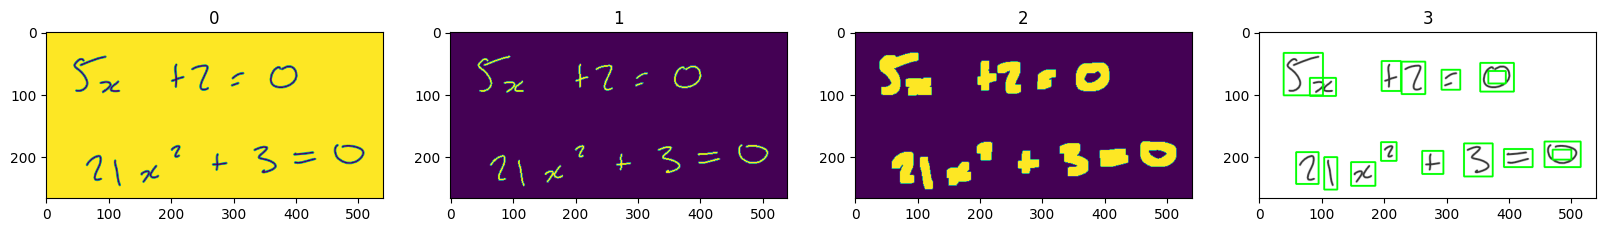

In [58]:
imgs = load_equations(r"C:\Users\b_wen\PythonProjects\HandMtoLat\test_equations")
img = imgs[1]
bboxes, img_stages = find_bboxes(img)
# display all images 

plt.figure(figsize=(20,10))
columns = 4

for i, image in enumerate(img_stages):
    plt.subplot(int(len(img_stages) / columns + 1), columns, i + 1)
    plt.title(i)
    plt.imshow(image)

# Structural analysis